### ___Clasificador de Radiografia___
---
>* Deteccion de neumonio en radiografias de niños menores de 9 años

In [24]:
# Importación de compatibilidad para garantizar que el código funcione en versiones más antiguas de Python
from __future__ import absolute_import, division, print_function, unicode_literals

# Librerías para manipulación y análisis de datos
import pandas as pd  # Manejo de datos en estructuras tipo DataFrame

# TensorFlow y Keras para aprendizaje profundo
import tensorflow as tf  # Framework de aprendizaje automático
from tensorflow.keras import datasets, layers, models  # type: ignore # Módulos para redes neuronales
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard # type: ignore

# Visualización de datos
import matplotlib.pyplot as plt  
import seaborn as sns


# Manejo de matrices y cálculos numéricos
import numpy as np  

# Manejo de archivos y operaciones del sistema
import os  

# Barra de progreso para mostrar el avance en bucles largos
from tqdm import tqdm  

# OpenCV para procesamiento de imágenes
import cv2  

# Para encontrar archivos según un patrón específico (ej. "*.jpg", "*.png")
from glob import glob

# Librerías para manipulación de imágenes
import sklearn  # Conjunto de herramientas para Machine Learning
import skimage  # Procesamiento de imágenes
from skimage.transform import resize  # Redimensionamiento de imágenes

# Librería para generación de números aleatorios
import random  # Funciones para generar números aleatorios y mezclar datos

# Manejo de fechas y horas para nombrar archivos o generar timestamps
import datetime  # Funcionalidades de fecha y hora

# Librerías para balancear datos en problemas de aprendizaje automático
from imblearn.over_sampling import RandomOverSampler  # Aumenta la cantidad de datos de clases minoritarias
from imblearn.under_sampling import RandomUnderSampler  # Reduce la cantidad de datos de clases mayoritarias

# Conversión de imágenes a escala de grises
from skimage.color import rgb2gray  # Convierte imágenes RGB a escala de grises

# Verificamos la versión de TensorFlow instalada
print(tf.__version__)  # Imprime la versión de TensorFlow para asegurarse de que está instalado correctamente


2.19.0


>* Importamos y procesamos dataset

In [3]:
import os
import numpy as np
import cv2
import skimage
from skimage.transform import resize
from skimage.color import rgb2gray
from tqdm import tqdm

# Definimos los directorios donde están las imágenes de entrenamiento y prueba
train_dir = "chest_xray/train/"  # Carpeta que contiene las imágenes de entrenamiento
test_dir =  "chest_xray/test/"   # Carpeta que contiene las imágenes de prueba

# Variable que indica si se deben cargar las imágenes desde los archivos o usar los datos previamente guardados en .npy
LOAD_FROM_IMAGES = False  # Si es False, se cargarán los datos desde los archivos .npy


# Función para cargar y procesar las imágenes desde las carpetas
def get_data(folder):
    X = []  # Lista para almacenar las imágenes procesadas
    y = []  # Lista para almacenar las etiquetas correspondientes

    # Recorremos todas las carpetas dentro de la carpeta principal (folder)
    for folderName in os.listdir(folder):
        # Ignoramos archivos ocultos o carpetas del sistema
        if not folderName.startswith('.'):
            # Asignamos etiquetas numéricas según la categoría de la imagen
            if folderName in ['NORMAL']:
                label = 0  # Normal se etiqueta como 0
            elif folderName in ['PNEUMONIA']:
                label = 1  # Neumonía se etiqueta como 1
            else:
                label = 2  # Cualquier otra categoría se etiqueta como 2 (posible error o categoría desconocida)

            # Iteramos sobre todas las imágenes en la carpeta actual
            for image_filename in tqdm(os.listdir(os.path.join(folder, folderName))):
                # Leemos la imagen
                img_file = cv2.imread(os.path.join(folder, folderName, image_filename))

                # Verificamos que la imagen se haya cargado correctamente
                if img_file is not None:
                    # Redimensionamos la imagen a 150x150 píxeles con 3 canales de color
                    img_file = resize(img_file, (150, 150, 3), mode='constant', anti_aliasing=True)

                    # Convertimos la imagen a escala de grises
                    img_file = rgb2gray(img_file)

                    # Convertimos la imagen en un array numérico
                    img_arr = np.asarray(img_file)

                    # Agregamos la imagen procesada y su etiqueta a las listas
                    X.append(img_arr)
                    y.append(label)

    # Convertimos las listas en arreglos de NumPy para facilitar su manejo en modelos de Machine Learning
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X, y  # Retornamos las imágenes y sus etiquetas
  

# Intentamos cargar los datos desde los archivos .npy
try:
    X_train = np.load('xtrain.npy')  # Carga las imágenes de entrenamiento
    y_train = np.load('ytrain.npy')  # Carga las etiquetas de entrenamiento
    X_test = np.load('xtest.npy')    # Carga las imágenes de prueba
    y_test = np.load('ytest.npy')    # Carga las etiquetas de prueba
    print("✅ Archivos .npy cargados exitosamente.")
    
except FileNotFoundError:
    print("⚠️ No se encontraron los archivos .npy, generando los datos desde las imágenes...")
    
    # Cargamos los datos de entrenamiento y prueba desde las imágenes
    X_train, y_train = get_data(train_dir)
    X_test, y_test = get_data(test_dir)
    
    # Guardamos los arrays procesados en archivos .npy para uso futuro
    np.save('xtrain.npy', X_train)  # Guarda las imágenes de entrenamiento
    np.save('ytrain.npy', y_train)  # Guarda las etiquetas de entrenamiento
    np.save('xtest.npy', X_test)    # Guarda las imágenes de prueba
    np.save('ytest.npy', y_test)    # Guarda las etiquetas de prueba
    
    print("✅ Datos generados y guardados en archivos .npy correctamente.")


⚠️ No se encontraron los archivos .npy, generando los datos desde las imágenes...


100%|██████████| 234/234 [00:42<00:00,  5.51it/s]


✅ Datos generados y guardados en archivos .npy correctamente.


>* Este fragmento de código carga y procesa imágenes de rayos X desde carpetas de entrenamiento (train_dir) y prueba (test_dir) para clasificarlas en NORMAL (etiqueta 0) y PNEUMONIA (etiqueta 1). Primero, intenta cargar los datos desde archivos previamente guardados en formato .npy para evitar reprocesar imágenes. Si estos archivos no existen, procesa las imágenes redimensionándolas a 150x150 píxeles, convirtiéndolas a escala de grises y almacenándolas como arreglos NumPy. Luego, guarda estos datos en archivos .npy para futuras ejecuciones, optimizando así el tiempo de carga y procesamiento en modelos de aprendizaje automático.

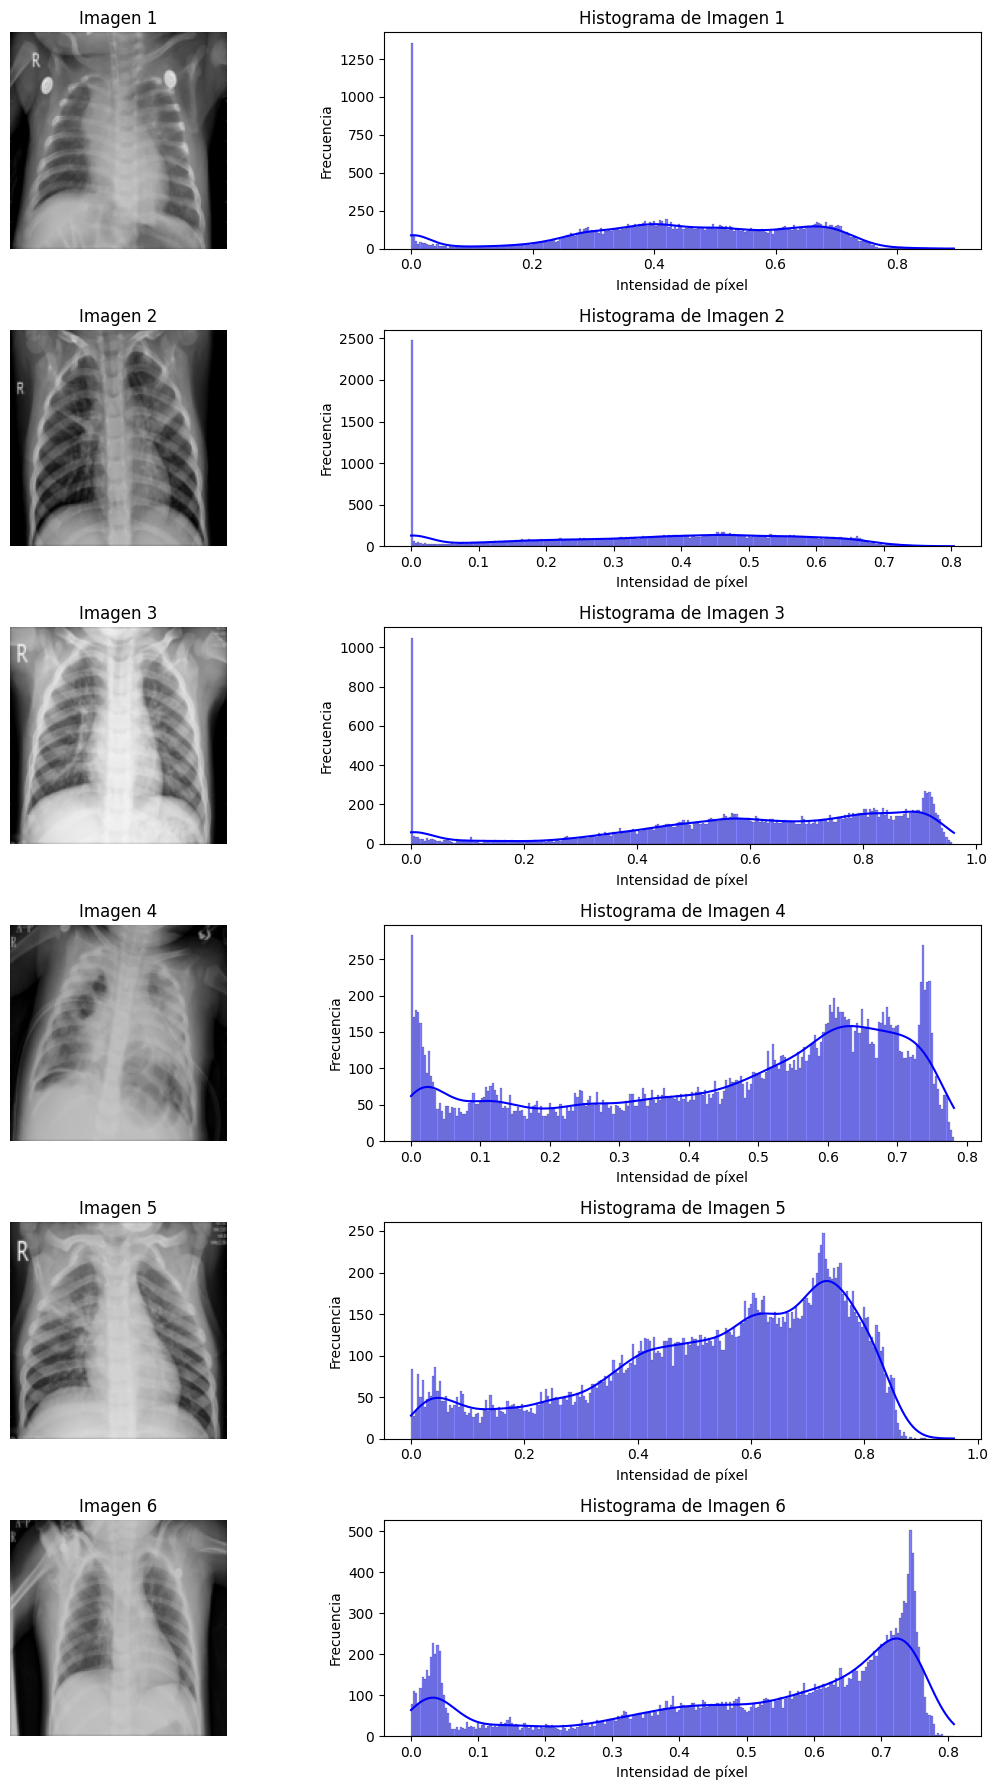

In [5]:
def plot_histograms(images, num_images=6):
    """
    Muestra múltiples imágenes junto con sus histogramas en subplots.
    
    Parámetros:
    - images: Lista de imágenes en escala de grises (matrices 2D).
    - num_images: Número de imágenes a mostrar (por defecto 6).
    """
    
    num_images = min(num_images, len(images))  # Evita errores si hay menos imágenes
    fig, axes = plt.subplots(num_images, 2, figsize=(12, num_images * 3))  # Subplots en columnas
    
    for i in range(num_images):
        img = images[i]

        # Subplot de la imagen
        axes[i, 0].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Imagen {i+1}")

        # Subplot del histograma
        sns.histplot(img.ravel(), bins=256, kde=True, ax=axes[i, 1], color='blue')
        axes[i, 1].set_title(f"Histograma de Imagen {i+1}")
        axes[i, 1].set_xlabel("Intensidad de píxel")
        axes[i, 1].set_ylabel("Frecuencia")

    plt.tight_layout()  # Ajusta los espacios entre gráficos
    plt.show()

# Llamamos la función con 6 imágenes de entrenamiento
plot_histograms(X_train[:6], num_images=6)

>* Este fragmento de código define la función plot_histograms, que visualiza múltiples imágenes en escala de grises junto con sus histogramas de intensidad de píxeles. La función toma como entrada un conjunto de imágenes y un número específico de imágenes a mostrar, organizándolas en subplots de dos columnas: una para la imagen y otra para su histograma correspondiente. Para mejorar la visualización, se utiliza la biblioteca Seaborn, lo que permite graficar histogramas más estilizados con líneas de densidad (KDE). La función ajusta dinámicamente el tamaño de los gráficos y distribuye los subplots de manera óptima. Finalmente, el código llama a esta función para mostrar seis imágenes de entrenamiento (X_train[:6]), proporcionando una manera eficiente y clara de analizar la distribución de intensidades en las imágenes procesadas.

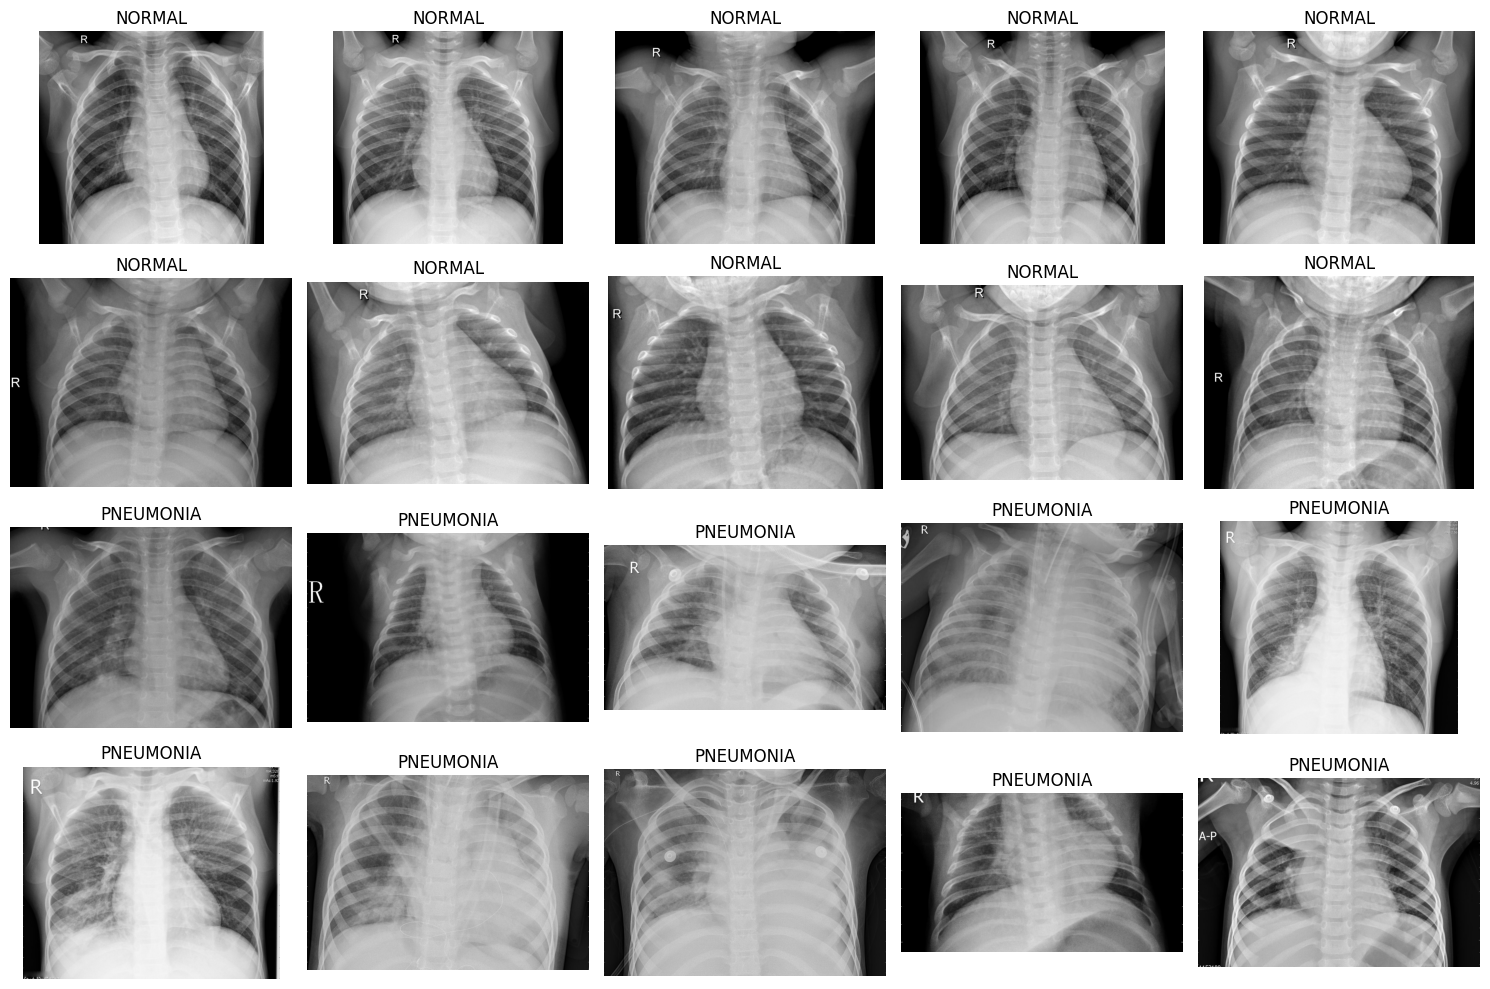

In [10]:
normal_images = glob('chest_xray/train/NORMAL/*')  # Imágenes de la clase NORMAL
pneumonia_images = glob('chest_xray/train/PNEUMONIA/*')  # Imágenes de la clase PNEUMONIA

def plot_images(normal_imgs, pneumonia_imgs, num_images=10):
    """
    Muestra 20 imágenes en total: 10 de 'NORMAL' y 10 de 'PNEUMONIA' en una cuadrícula de 4 filas x 5 columnas.
    
    Parámetros:
    - normal_imgs: Lista de rutas de imágenes normales.
    - pneumonia_imgs: Lista de rutas de imágenes con neumonía.
    - num_images: Número de imágenes a mostrar por categoría (default = 10).
    """
    
    # Seleccionar aleatoriamente 'num_images' imágenes de cada clase
    normal_sample = random.sample(normal_imgs, num_images)
    pneumonia_sample = random.sample(pneumonia_imgs, num_images)

    # Crear subplots de 4 filas x 5 columnas
    fig, axes = plt.subplots(4, 5, figsize=(15, 10))

    # Mostrar imágenes normales en las dos primeras filas
    for i in range(num_images):
        img = cv2.imread(normal_sample[i])  # Cargar imagen
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB para visualizar correctamente
        row, col = divmod(i, 5)  # Obtener la posición en la cuadrícula
        axes[row, col].imshow(img)
        axes[row, col].axis('off')  # Ocultar ejes
        axes[row, col].set_title("NORMAL")  # Título de la imagen

    # Mostrar imágenes con neumonía en las dos últimas filas
    for i in range(num_images):
        img = cv2.imread(pneumonia_sample[i])  # Cargar imagen
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir a RGB
        row, col = divmod(i, 5)  # Ajustar posición en la cuadrícula
        axes[row + 2, col].imshow(img)
        axes[row + 2, col].axis('off')  # Ocultar ejes
        axes[row + 2, col].set_title("PNEUMONIA")  # Título de la imagen

    plt.tight_layout()  # Ajustar espacios entre gráficos
    plt.show()

# Llamamos la función para mostrar las imágenes
plot_images(normal_images, pneumonia_images, num_images=10)

/var/folders/zz/w7h5lp_x69b7dwh3mvfqq6pc0000gq/T/ipykernel_32534/2993398487.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=lab, palette="Blues")  # Gráfico de conteo
/var/folders/zz/w7h5lp_x69b7dwh3mvfqq6pc0000gq/T/ipykernel_32534/2993398487.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([map_characters[label] for label in dist.index], fontsize=12)


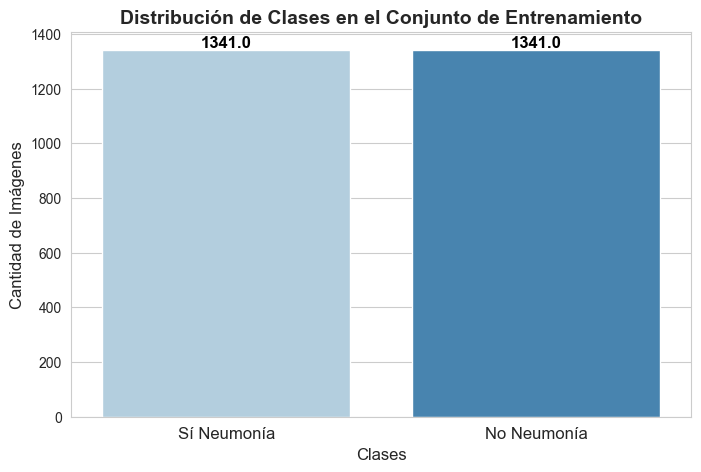

{0: 'No Neumonía', 1: 'Sí Neumonía'}


In [13]:
# Mapeo de etiquetas numéricas a nombres de clases
map_characters = {0: 'No Neumonía', 1: 'Sí Neumonía'}
dict_characters = map_characters

# Crear un DataFrame con las etiquetas de entrenamiento
df = pd.DataFrame()
df["labels"] = y_train  # Asigna las etiquetas a una columna llamada 'labels'

# Obtener la distribución de clases
lab = df['labels']
dist = lab.value_counts()

# Configurar estilo del gráfico
sns.set_style("whitegrid")

# Crear la figura
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=lab, palette="Blues")  # Gráfico de conteo

# Agregar etiquetas de los valores sobre las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# Ajustar las etiquetas del eje X con los nombres de las clases
ax.set_xticklabels([map_characters[label] for label in dist.index], fontsize=12)

# Agregar título y etiquetas de ejes
plt.title("Distribución de Clases en el Conjunto de Entrenamiento", fontsize=14, fontweight='bold')
plt.xlabel("Clases", fontsize=12)
plt.ylabel("Cantidad de Imágenes", fontsize=12)

# Mostrar el gráfico
plt.show()

# Imprimir el diccionario de clases
print(dict_characters)

In [14]:
X_train.shape

(2682, 150, 150)

>* Este código reestructura los datos de entrada agregando una dimensión extra (1 canal) para que las imágenes en escala de grises sean compatibles con redes neuronales convolucionales (CNNs).

In [15]:
X_trainReshaped = X_train.reshape(len(X_train),150,150,1)
X_testReshaped = X_test.reshape(len(X_test),150,150,1)

Este fragmento de código define una Red Neuronal Convolucional (CNN) en TensorFlow/Keras para clasificar imágenes en Neumonía y No Neumonía. La arquitectura sigue estos pasos:

>* 1. Capa de Entrada: Recibe imágenes en escala de grises de tamaño 150x150x1.
>* 2. Capas Convolucionales: Usa 4 capas Conv2D, aumentando los filtros (32 → 64 → 128 → 128) para extraer características.
>* 3. MaxPooling: Reduce la dimensión de la imagen tras cada convolución, manteniendo la información más importante.
>* 4. Normalización (BatchNormalization): Asegura que las activaciones estén bien distribuidas, acelerando el entrenamiento.
>* 5. Aplanamiento (Flatten): Transforma las características extraídas en un vector 1D.
>* 6. Capa Densa (Dense): Contiene 128 neuronas con activación ReLU para aprender patrones complejos.
>* 7. Regularización (Dropout(0.5)): Evita el sobreajuste apagando el 50% de las neuronas en la capa densa.
>* 8. Capa de Salida (Dense(2, activation='softmax')): Predice la clase (0 = No Neumonía, 1 = Neumonía).
>* 9. Se imprime el model.summary() para visualizar la arquitectura final.

In [16]:
# Inicializamos el modelo secuencial
model = models.Sequential()

# Primera capa convolucional + MaxPooling
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1))) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())  # Normaliza los valores de activación para mejorar estabilidad

# Segunda capa convolucional + MaxPooling
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Tercera capa convolucional + MaxPooling
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Cuarta capa convolucional (sin MaxPooling, extrae características más detalladas)
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())

# Aplanamos la salida para conectarla con la capa densa
model.add(layers.Flatten())

# Capa densa completamente conectada
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Reduce el sobreajuste apagando el 50% de las neuronas

# Capa de salida con 2 neuronas (clasificación binaria) y activación softmax
model.add(layers.Dense(2, activation='softmax'))

# Mostramos el resumen del modelo
model.summary()

/Users/danielapinzon/Downloads/Udemy/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 74, 74, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,928,450 (14.99 MB)

 Trainable params: 3,927,746 (14.98 MB)

 Non-trainable params: 704 (2.75 KB)

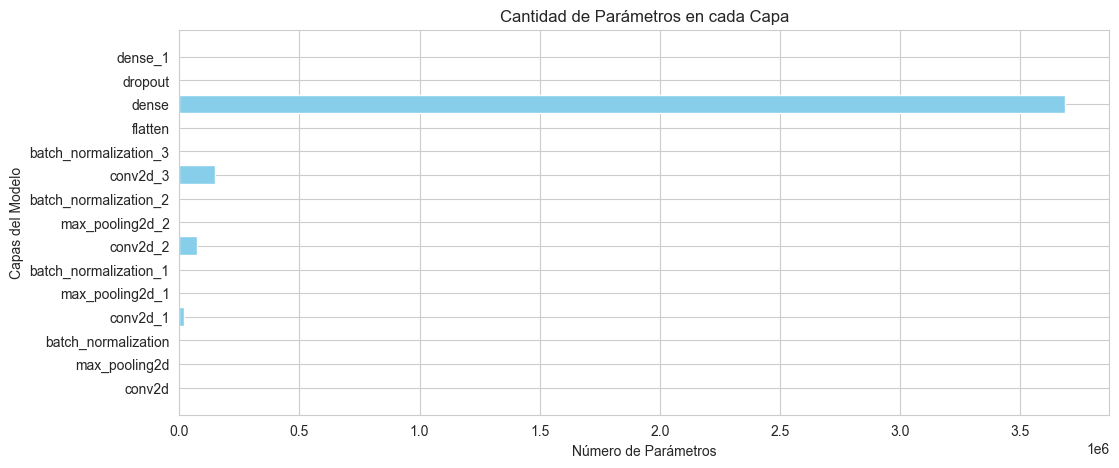

In [19]:
# Extraer información del modelo
layers_names = [layer.name for layer in model.layers]
layers_params = [layer.count_params() for layer in model.layers]

# Graficar
plt.figure(figsize=(12,5))
plt.barh(layers_names, layers_params, color='skyblue')
plt.xlabel("Número de Parámetros")
plt.ylabel("Capas del Modelo")
plt.title("Cantidad de Parámetros en cada Capa")
plt.show()

In [25]:
# 🔹 Compilamos el modelo con el optimizador Adam y la función de pérdida adecuada
model.compile(
    optimizer='adam',  # Algoritmo de optimización
    loss='sparse_categorical_crossentropy',  # Función de pérdida para clasificación multiclase
    metrics=['accuracy']  # Métrica de evaluación
)

# 🔹 Configuración para guardar logs de TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# 🔹 EarlyStopping: Detiene el entrenamiento si la validación no mejora después de 5 épocas
early_stopping = EarlyStopping(
    monitor='val_loss',  # Observamos la pérdida en la validación
    patience=5,  # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True  # Restaurar el mejor modelo
)

# 🔹 ReduceLROnPlateau: Reduce la tasa de aprendizaje si la validación no mejora
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Observamos la pérdida en la validación
    factor=0.5,  # Reducir la tasa de aprendizaje a la mitad
    patience=3,  # Número de épocas sin mejora antes de reducir LR
    min_lr=1e-6  # Valor mínimo para la tasa de aprendizaje
)

# 🔹 Entrenamiento del modelo con callbacks
history = model.fit(
    X_trainReshaped,  # Conjunto de imágenes de entrenamiento
    y_train,  # Etiquetas de entrenamiento
    epochs=20,  # Número total de épocas
    validation_data=(X_testReshaped, y_test),  # Validación en cada época
    callbacks=[tensorboard_callback, early_stopping, reduce_lr]  # Callbacks para mejorar el entrenamiento
)

# 🔹 Guardamos el modelo entrenado
model.save("modelo_neumonia.h5")

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 28s 317ms/step - accuracy: 0.8340 - loss: 1.2657 - val_accuracy: 0.6250 - val_loss: 6.6073 - learning_rate: 0.0010
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 386ms/step - accuracy: 0.9392 - loss: 0.1791 - val_accuracy: 0.6250 - val_loss: 24.5244 - learning_rate: 0.0010
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 29s 341ms/step - accuracy: 0.9465 - loss: 0.1410 - val_accuracy: 0.6250 - val_loss: 13.9443 - learning_rate: 0.0010
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - accuracy: 0.9622 - loss: 0.1084 - val_accuracy: 0.6250 - val_loss: 6.9706 - learning_rate: 0.0010
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 38s 448ms/step - accuracy: 0.9655 - loss: 0.0876 - val_accuracy: 0.6250 - val_loss: 6.5889 - learning_rate: 5.0000e-04
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 30s 358ms/step - accuracy: 0.9766 - loss: 0.0660 - val_accuracy: 0.6442 - val_loss: 5.2619 - learning_rate: 5.0000e-04
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 30s 354ms/step - accuracy: 0.9824 

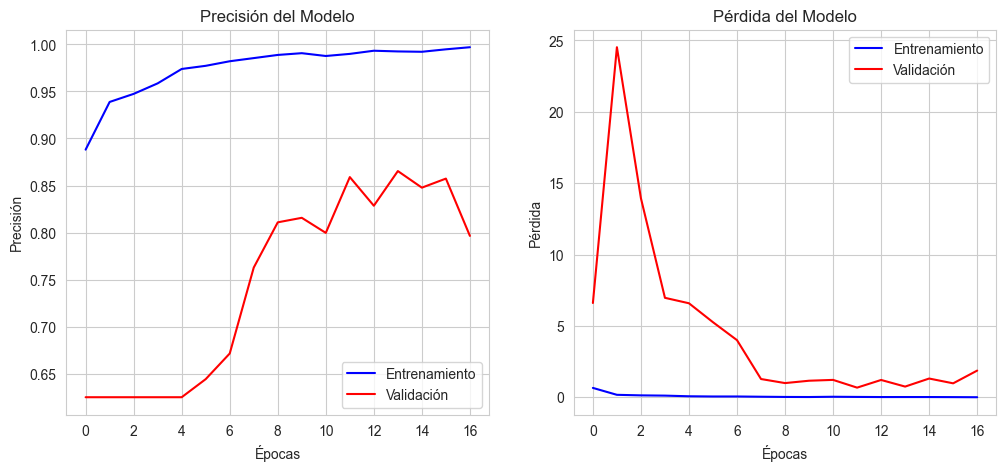

In [26]:
# Obtener datos del historial de entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear figura con dos subgráficos
plt.figure(figsize=(12,5))

# 🔹 Gráfico de Precisión (Accuracy)
plt.subplot(1,2,1)
plt.plot(acc, label='Entrenamiento', color='blue')
plt.plot(val_acc, label='Validación', color='red')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión del Modelo')
plt.legend()

# 🔹 Gráfico de Pérdida (Loss)
plt.subplot(1,2,2)
plt.plot(loss, label='Entrenamiento', color='blue')
plt.plot(val_loss, label='Validación', color='red')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida del Modelo')
plt.legend()

plt.show()

In [27]:
test_loss, test_acc = model.evaluate(X_testReshaped, y_test)
print(test_acc)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9292 - loss: 0.3195
0.8589743375778198


In [28]:
test_loss, test_acc = model.evaluate(X_trainReshaped, y_train)

84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.9496 - loss: 0.1346


>* El modelo de clasificación de imágenes ha logrado una precisión en entrenamiento del 92.92% y una precisión en validación del 85.89%, lo que indica que ha aprendido correctamente los patrones del conjunto de datos. Sin embargo, la gráfica de entrenamiento muestra un posible sobreajuste, ya que la precisión en entrenamiento es muy alta (~100%) mientras que la precisión en validación es inestable y la pérdida (val_loss) presenta fluctuaciones. Esto sugiere que el modelo está memorizando los datos de entrenamiento en lugar de generalizar bien a datos no vistos. Para mejorar el rendimiento en validación, se recomienda aplicar data augmentation, aumentar el Dropout en la capa densa y ajustar la tasa de aprendizaje para mejorar la estabilidad del modelo. 